In [1]:
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stateinterpreter.MD import Loader
from stateinterpreter.classifier import Classifier
from stateinterpreter.plot import plot_cvpath, plot_states, plot_combination_cvs_relevant_features


In [2]:
import re
def get_residue(s):
    m = re.search(r'\d+$', s)
    return m.group() if m else None

def _get_angle_groups(angle_names):
    groups = []
    for s in angle_names:
        groups.append(get_residue(s))
    return np.array(groups, dtype=int)

In [3]:
BPTI_data_path = '../../../data/md_datasets/BPTI-unbiased/'
colvar_file = BPTI_data_path + 'COLVAR'
traj_dict = {
        'trajectory' : BPTI_data_path+'all_trj_10ns.trr',
        'topology' : BPTI_data_path+'bpti-protein.pdb'
    }
desc_path = '../../../data/md_datasets/BPTI-unbiased/descritpors.pkl'
descriptors = pd.read_pickle(desc_path)
# Compute descriptors from Trajectory
data = Loader(colvar_file, descriptors=descriptors, kbt=2.5)
data.load_trajectory(traj_dict, descriptors=False)

In [4]:
cv_list = ['tica1', 'tica2']
bounds = [(-1,1), (-1,1)]
data.identify_states(cv_list, bounds, bw_method=0.3, fes_cutoff=2.5)

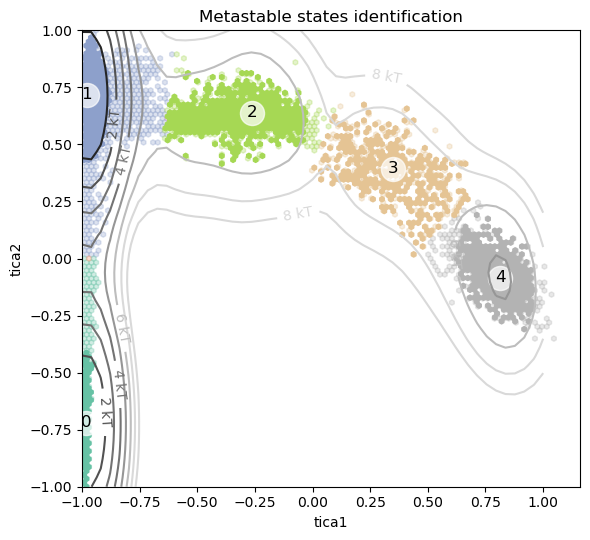

In [5]:
plot_states(data, fes_isolines=True)

In [6]:
for idx in range(data.n_basins):
    l = len(data.basins.loc[ (data.basins['basin'] == idx) & (data.basins['selection'] == True)])
    print(f"{idx} -> {l}")

0 -> 26227
1 -> 71427
2 -> 1228
3 -> 416
4 -> 861


In [7]:
select_feat = 'sin_|cos_'
sample = data.sample(400, regex_filter = select_feat)

In [ ]:
groups = _get_angle_groups(sample.features)
regularizers = np.geomspace(0.1, 1, 12)
dset = sample.train_test_dataset()
classifier = Classifier(dset, sample.features)
classifier.compute(regularizers, max_iter= 100000, groups=groups)

(-2.0, 0.0)

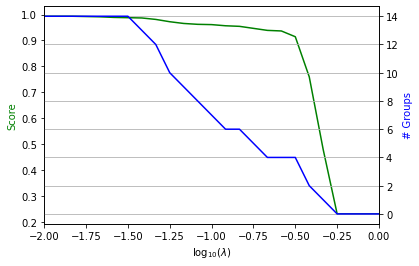

In [16]:
num_groups = []
for reg in regularizers:
    selected = classifier._get_selected(reg)
    unique_idxs = set()
    for state in selected:
        for data in state:
            unique_idxs.add(data[0])
    num_groups.append(len(unique_idxs))

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.grid()
ax2.plot(np.log10(regularizers), num_groups, 'b-')
ax1.plot(np.log10(regularizers), classifier._crossval, 'g-')
#ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

ax1.set_xlabel(r"$\log_{10}(\lambda)$")
ax1.set_ylabel('Score', color='g')
ax2.set_ylabel('# Groups', color='b')
ax1.set_xlim(np.log10(regularizers)[0],np.log10(regularizers)[-1])


State 0:
	 31.055% | 38
	 25.779% | 42
	 14.74%  | 14
	 10.119% | 39
	 7.678%  | 17
	 4.396%  | 36
	 2.671%  | 10
	 1.863%  | 35
	 1.162%  | 13
	 0.276%  | 15
	 0.125%  | 40
	 0.062%  | 6
	 0.038%  | 11
	 0.036%  | 9
State 1:
	 62.676% | 42
	 10.85%  | 14
	 10.119% | 39
	 6.709%  | 17
	 5.365%  | 38
	 1.125%  | 36
	 0.973%  | 35
	 0.936%  | 10
	 0.551%  | 40
	 0.236%  | 13
	 0.226%  | 6
	 0.222%  | 15
	 0.008%  | 11
	 0.006%  | 9
State 2:
	 43.649% | 42
	 23.714% | 36
	 19.983% | 14
	 4.577%  | 38
	 2.448%  | 39
	 2.097%  | 17
	 1.602%  | 10
	 0.694%  | 35
	 0.364%  | 6
	 0.328%  | 13
	 0.242%  | 40
	 0.2%    | 15
	 0.089%  | 9
	 0.012%  | 11
State 3:
	 37.494% | 42
	 26.129% | 14
	 12.897% | 38
	 11.608% | 36
	 4.671%  | 39
	 2.49%   | 17
	 1.357%  | 10
	 0.981%  | 6
	 0.783%  | 35
	 0.751%  | 13
	 0.53%   | 40
	 0.203%  | 15
	 0.085%  | 9
	 0.021%  | 11


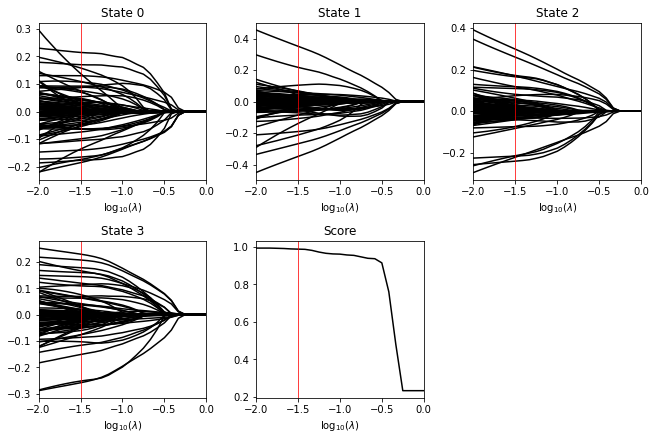

In [17]:
reg = 10**(-1.5)
plot_cvpath(classifier, reg);
classifier.print_selected(reg)